<a href="https://colab.research.google.com/github/ninarina12/phononDoS_tutorial/blob/main/phononDoS_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ninarina12/phononDoS_tutorial.git

Cloning into 'phononDoS_tutorial'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 65 (delta 27), reused 53 (delta 15), pack-reused 0
Unpacking objects: 100% (65/65), done.


In [2]:
cd phononDoS_tutorial

/content/phononDoS_tutorial


In [3]:
pip install ase pymatgen e3nn

     |████████████████████████████████| 2.2 MB 12.1 MB/s 
     |████████████████████████████████| 3.4 MB 43.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 384 kB 43.4 MB/s 
     |████████████████████████████████| 98 kB 8.6 MB/s 
     |████████████████████████████████| 65 kB 3.9 MB/s 
     |████████████████████████████████| 23.9 MB 14 kB/s 
     |████████████████████████████████| 28.5 MB 54 kB/s 
     |████████████████████████████████| 292 kB 53.6 MB/s 
     |████████████████████████████████| 109 kB 51.3 MB/s 
  Using cached numpy-1.21.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
     |████████████████████████████████| 546 kB 48.4 MB/s 
  Created wheel for pymatgen: filename=pymatgen-2022.0.16-cp37-cp37m-linux_x86_64.whl size=3730941 sha256=a2c91dd8a75c0fa10a47a80d727dd0445a00fe9643d9751ee45ace5

In [4]:
pip install torch-scatter torch-cluster torch-sparse torch-spline-conv -f https://pytorch-geometric.com/whl/torch-$(python -c "import torch; print(torch.__version__)").html

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 10.4 MB 10.9 MB/s 
     |████████████████████████████████| 1.6 MB 7.4 MB/s 
     |████████████████████████████████| 3.7 MB 42.4 MB/s 
     |████████████████████████████████| 870 kB 37.2 MB/s 


In [5]:
pip install torch-geometric

     |████████████████████████████████| 325 kB 12.4 MB/s 
     |████████████████████████████████| 407 kB 23.4 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=31b95d7fe37512b7619d4835affe0ea1496c11508b13b3c6b7a21e99e901759e
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully built torch-geometric


In [7]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn.nn.models.v2103.gate_points_networks import SimpleNetwork
from typing import Dict, Union

# crystal structure data
from pymatgen.core.periodic_table import Element
from ase import Atoms
from ase.neighborlist import neighbor_list

# data pre-processing and visualization
import numpy as np
import matplotlib.pyplot as plt

# utilities
import time
from tqdm import tqdm
from utils import load_data, train_valid_test_split, plot_example, train, plot_predictions, bar_format, colors

default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

In [11]:
# load data
df, species = load_data('data.csv')
df.head()

parsing cif files ...


  0%|          | 0/1521 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pymatgen/io/cif.py:1165: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))
100%|██████████| 1521/1521 [00:14<00:00, 103.89it/s]


,mp_id,structure,phfreq,phdos,phfreq_orig,phdos_orig,formula,species
0,mp-1000,"[[0. 0. 0.] Ba, [ 5.37237038e-16 6.02243068e+...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.00034002174986516386, 0.03610538808788403, ...","[-2.414220753382029, -1.4142208327838217, -0.4...","[7.280378430209286e-05, 0.00014027547162405823...",Ba1Te1,"[Ba, Te]"
1,mp-1002124,"[[0. 0. 0.] Hf, [-4.53165633e-16 2.16467650e+...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0014231676036337041, 0.030388907952580754, ...","[-2.414220753382029, -1.4142208327838217, -0.4...","[0.0005128293757887676, 0.0007912274464215503,...",Hf1C1,"[Hf, C]"
2,mp-1002164,"[[0. 0. 0.] Ge, [-2.62477319e-16 1.97726732e+...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[2.1876054457560598e-05, 0.0008632550177437075...","[-2.414220753382029, -1.4142208327838217, -0.4...","[1.049188744147034e-05, 1.3114601777082313e-05...",Ge1C1,"[Ge, C]"
3,mp-10044,[[2.77555756e-16 6.19484993e+00 7.21644966e-16...,"[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[2.4923734727337427e-05, 0.0010122075381107955...","[-2.414220753382029, -1.4142208327838217, -0.4...","[1.6246064098660143e-05, 2.0344763470911068e-0...",B1As1,"[B, As]"
4,mp-1008223,"[[0. 0. 0.] Ca, [ 2.22044605e-16 2.81463269e+...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.002005968459267972, 0.1001663906915073, 0.4...","[-2.414220753382029, -1.4142208327838217, -0.4...","[0.0001802247201930491, 0.00032482552437295326...",Ca1Se1,"[Ca, Se]"


split train/dev ...


100%|██████████| 64/64 [00:00<00:00, 148.70it/s]


split valid/test ...


100%|██████████| 62/62 [00:00<00:00, 178.75it/s]


number of training examples: 1192
number of validation examples: 137
number of testing examples: 192
total number of examples: 1521


findfont: Font family ['lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['lato'] not found. Falling back to DejaVu Sans.


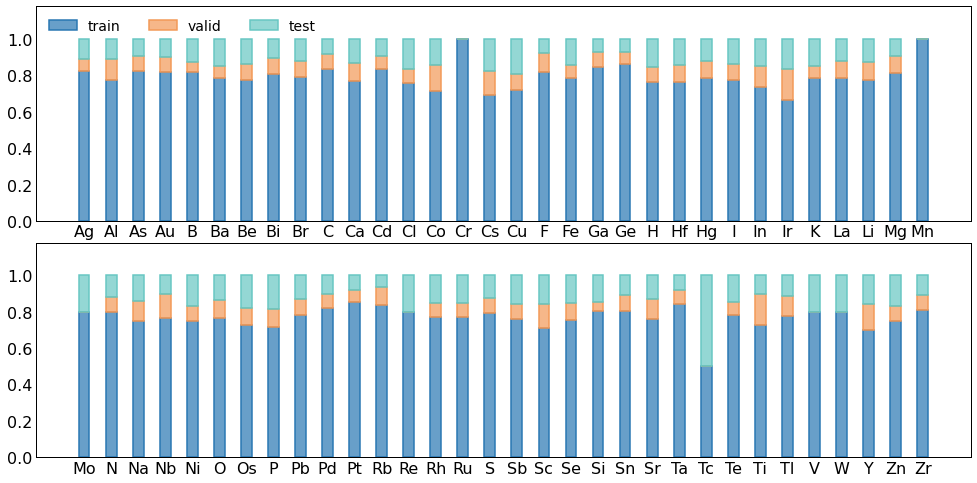

In [12]:
# train/valid/test split
idx_train, idx_valid, idx_test = train_valid_test_split(df, species, seed=12, plot=True)

In [14]:
# one-hot encoding atomic mass
type_encoding = {}
specie_am = []
for Z in tqdm(range(1, 119), bar_format=bar_format):
    specie = Element.from_Z(Z)
    type_encoding[specie.symbol] = Z
    specie_am.append(specie.atomic_mass)

type_onehot = torch.diag(torch.tensor(specie_am))

100%|██████████| 118/118 [00:00<00:00, 61374.98it/s]


In [45]:
# build data
def build_data(entry, type_encoding, type_onehot, r_max=5.):
    symbols = [specie.symbol for specie in entry.structure.species]
    positions = torch.from_numpy(entry.structure.cart_coords.copy())
    cell = torch.from_numpy(entry.structure.lattice.matrix.copy())
    crystal = Atoms(symbols=symbols, positions=positions, cell=cell, pbc=True)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images / copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=crystal, cutoff=r_max, self_interaction=True)
    
    # calculate edge lengths
    batch = positions.new_zeros(positions.shape[0], dtype=torch.long)
    edge_batch = batch[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->j', torch.tensor(edge_shift, dtype=default_dtype),
                               cell.unsqueeze(0)[edge_batch]))
    edge_len = np.around(np.sqrt((edge_vec**2).sum(dim=1).numpy()), decimals=2)
    
    data = tg.data.Data(
        pos=positions,
        lattice=cell.unsqueeze(0),
        symbol=symbols,
        x=type_onehot[[type_encoding[specie] for specie in symbols]],
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_len=edge_len,
        phdos=torch.from_numpy(entry.phdos).unsqueeze(0)
    )
    
    return data

r_max = 5 # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)

100%|██████████| 1521/1521 [00:34<00:00, 43.96it/s]


findfont: Font family ['lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['lato'] not found. Falling back to DejaVu Sans.


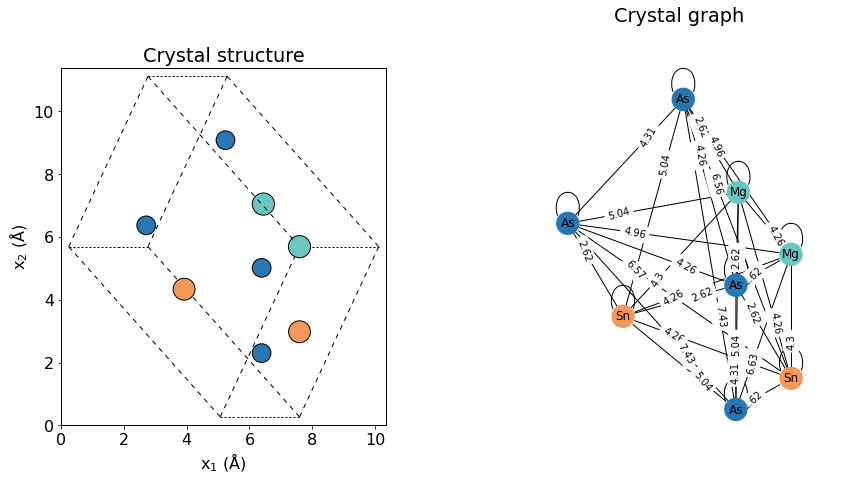

In [17]:
plot_example(df, i=12, label_edges=True)

In [46]:
batch_size = 1
dataloader_train = tg.loader.DataLoader(df.iloc[idx_train]['data'].values, batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(df.iloc[idx_valid]['data'].values, batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(df.iloc[idx_test]['data'].values, batch_size=batch_size)

average number of neighbors (train/valid/test): 30.022166361974406 / 29.264765784114054 / 28.156626506024097


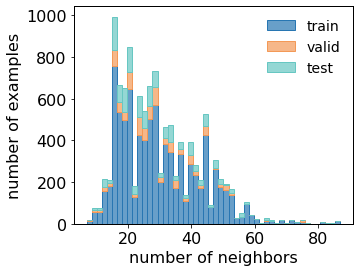

In [19]:
# calculate average number of neighbors
def get_neighbors(df, idx):
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)

n_train = get_neighbors(df, idx_train)
n_valid = get_neighbors(df, idx_valid)
n_test = get_neighbors(df, idx_test)

fig, ax = plt.subplots(1,1, figsize=(5,4))
b = 0.
bins = 50
for (d, c), n in zip(colors.items(), [n_train, n_valid, n_test]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('number of neighbors')
ax.set_ylabel('number of examples')
ax.legend(frameon=False)

print('average number of neighbors (train/valid/test):', n_train.mean(), '/', n_valid.mean(), '/', n_test.mean())

In [20]:
class SimplePeriodicNetwork(SimpleNetwork):
    def __init__(self, in_dim, em_dim, **kwargs):
        """The keyword `pool_nodes` is used by SimpleNetwork to determine
        whether we sum over all atom contributions per example. In this example,
        we want use a mean operation instead, so we will override this behavior.
        """
        
        self.pool = False
        if kwargs['pool_nodes'] == True:
            kwargs['pool_nodes'] = False
            kwargs['num_nodes'] = 1.
            self.pool = True
        super().__init__(**kwargs)

        # further embed the mass-weighted one-hot encoding
        self.fc1 = nn.Linear(in_dim, em_dim)

    # Overwriting preprocess method of SimpleNetwork to adapt for periodic boundary data
    def preprocess(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        if 'batch' in data:
            batch = data['batch']
        else:
            batch = data['pos'].new_zeros(data['pos'].shape[0], dtype=torch.long)

        edge_src = data['edge_index'][0]  # Edge source
        edge_dst = data['edge_index'][1]  # Edge destination

        # We need to compute this in the computation graph to backprop to positions
        # We are computing the relative distances + unit cell shifts from periodic boundaries
        edge_batch = batch[edge_src]
        edge_vec = (data['pos'][edge_dst]
                    - data['pos'][edge_src]
                    + torch.einsum('ni,nij->j', data['edge_shift'], data['lattice'][edge_batch]))

        return batch, data['x'], edge_src, edge_dst, edge_vec

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        # if pool_nodes was set to True, use scatter_mean to aggregate
        data.x = F.relu(self.fc1(data.x))
        output = super().forward(data)
        
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # Take mean over atoms per example
            output = F.relu(output)
            maxima, _ = torch.max(output, dim=1)
            output = output.div(maxima.unsqueeze(1))
            return output
        
        else:
            output = F.relu(output)
            maxima, _ = torch.max(output, dim=1)
            output = output.div(maxima.unsqueeze(1))
            return output

In [21]:
out_dim = len(df.iloc[0]['phfreq'])
em_dim = 64
model = SimplePeriodicNetwork(
    in_dim=118,
    em_dim=em_dim,
    irreps_in=str(em_dim)+"x0e",    # one-hot scalars (L=0 and even parity) on each atom to represent atom type
    irreps_out=str(out_dim)+"x0e",  # out_dim scalars (L=0 and even parity) to output
    max_radius=r_max,               # cutoff radius for convolution
    num_neighbors=n_train.mean(),   # scaling factor based on the typical number of neighbors
    pool_nodes=True,
)

print(model)

SimplePeriodicNetwork(
  (mp): MessagePassing(
    (layers): ModuleList(
      (0): Compose(
        (first): Convolution(
          (sc): FullyConnectedTensorProduct(64x0e x 1x0e -> 150x0e+50x1o+50x2e | 9600 paths | 9600 weights)
          (lin1): FullyConnectedTensorProduct(64x0e x 1x0e -> 64x0e | 4096 paths | 4096 weights)
          (fc): FullyConnectedNet[10, 100, 192]
          (tp): TensorProduct(64x0e x 1x0e+1x1o+1x2e -> 64x0e+64x1o+64x2e | 192 paths | 192 weights)
          (lin2): FullyConnectedTensorProduct(64x0e+64x1o+64x2e x 1x0e -> 150x0e+50x1o+50x2e | 16000 paths | 16000 weights)
          (lin3): FullyConnectedTensorProduct(64x0e+64x1o+64x2e x 1x0e -> 1x0e | 64 paths | 64 weights)
        )
        (second): Gate (150x0e+50x1o+50x2e -> 50x0e+50x1o+50x2e)
      )
      (1): Compose(
        (first): Convolution(
          (sc): FullyConnectedTensorProduct(50x0e+50x1o+50x2e x 1x0e -> 250x0e+50x1o+50x1e+50x2o+50x2e | 17500 paths | 17500 weights)
          (lin1): FullyConne

In [22]:
opt = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)

loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()

In [36]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

run_name = 'model_' + time.strftime("%y%m%d", time.localtime())
print(run_name)

torch device: cuda:0
model_211102


In [39]:
for results in train(model, opt, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, max_iter=64,
                     scheduler=scheduler, device=device):
    with open(run_name + '.torch', 'wb') as f:
        torch.save(results, f)

Iteration    1    batch  1192 /  1192   train loss =    0.083   valid loss =    0.086   elapsed time = 00:01:45
Iteration    2    batch  1192 /  1192   train loss =    0.069   valid loss =    0.070   elapsed time = 00:04:04
Iteration    3    batch  1192 /  1192   train loss =    0.063   valid loss =    0.061   elapsed time = 00:06:20


KeyboardInterrupt: ignored

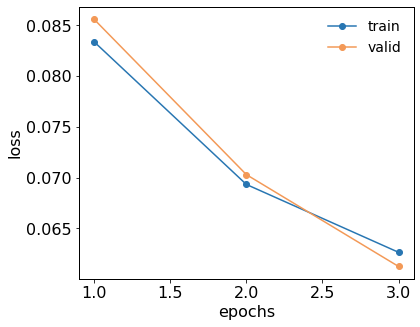

In [40]:
saved = torch.load(run_name + '.torch')
steps = [d['step'] + 1 for d in saved['dynamics']]
valid = [d['valid']['loss'] for d in saved['dynamics']]
train = [d['train']['loss'] for d in saved['dynamics']]

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(steps, train, 'o-', label="train", color=colors['train'])
ax.plot(steps, valid, 'o-', label="valid", color=colors['valid'])
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend(frameon=False);

In [47]:
# predict on all data
model.load_state_dict(torch.load(run_name + '.torch')['state'])
dataloader = tg.loader.DataLoader(df['data'].values, batch_size=64)
df['mse'] = 0.
df['phdos_pred'] = np.empty((len(df), 0)).tolist()

model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.phdos, reduction='none').mean(dim=-1).cpu().numpy()
        df.loc[i0:i0 + len(d.phdos) - 1, 'phdos_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.phdos) - 1, 'mse'] = loss
        i0 += len(d.phdos)
        
df['phdos_pred'] = df['phdos_pred'].map(lambda x: x[0])

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 24/24 [00:13<00:00,  1.81it/s]


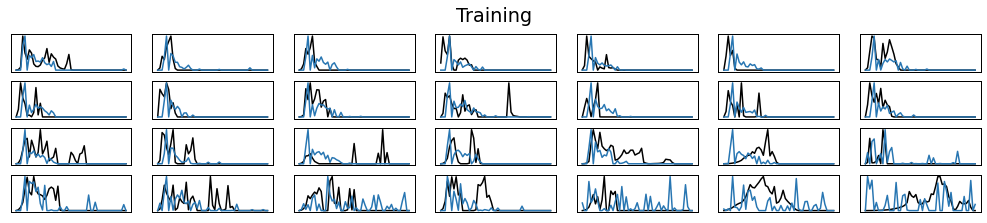

In [48]:
plot_predictions(df, idx_train, 'Training')

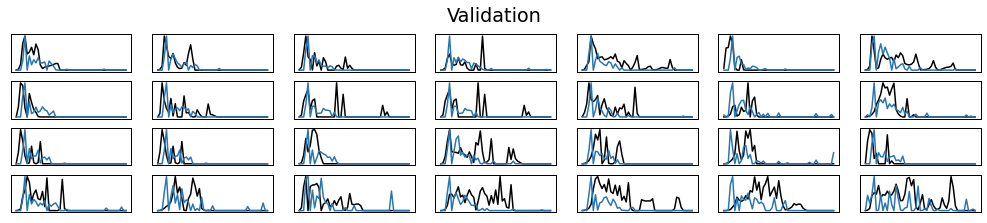

In [49]:
plot_predictions(df, idx_valid, 'Validation')

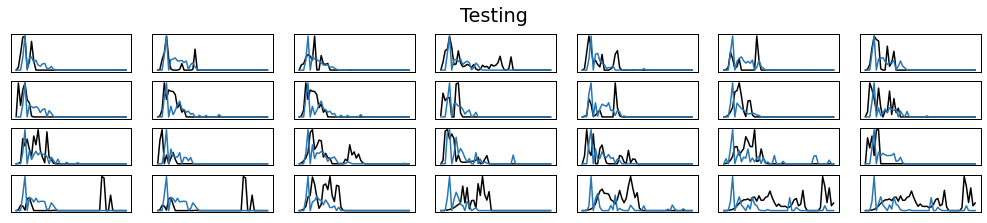

In [50]:
plot_predictions(df, idx_test, 'Testing')